In [58]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

import sosnet_model
import os
import matplotlib.pyplot as plt
import cv2
torch.no_grad()

In [59]:
image_path = 'data/NotreDame1.jpg'
image = Image.open(image_path)

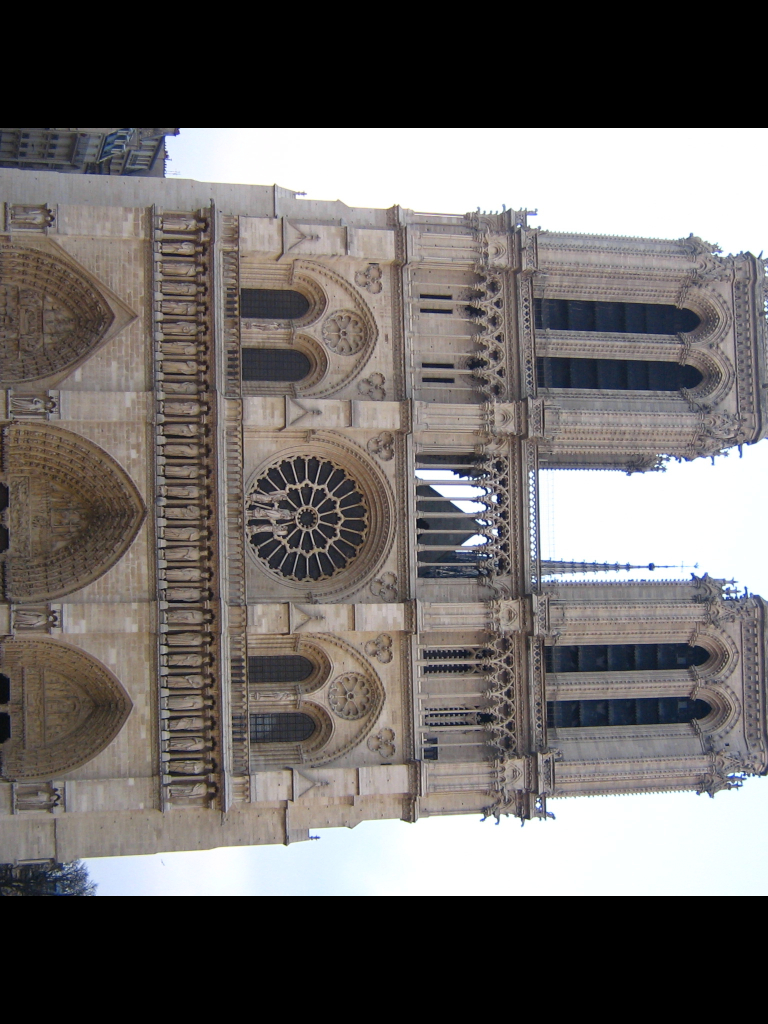

In [60]:
rotated_img = image.rotate(-90)
rotated_img

In [61]:
# convert img to tensor
tensor = transforms.ToTensor()
tensor_img = tensor(rotated_img)

In [62]:
# simulate illumination changes
illumination = transforms.Compose([
    transforms.ColorJitter(brightness=1, contrast=0.4,
                           saturation=0.7, hue = 0.2)
])
illumination_changed_img = illumination(tensor_img)

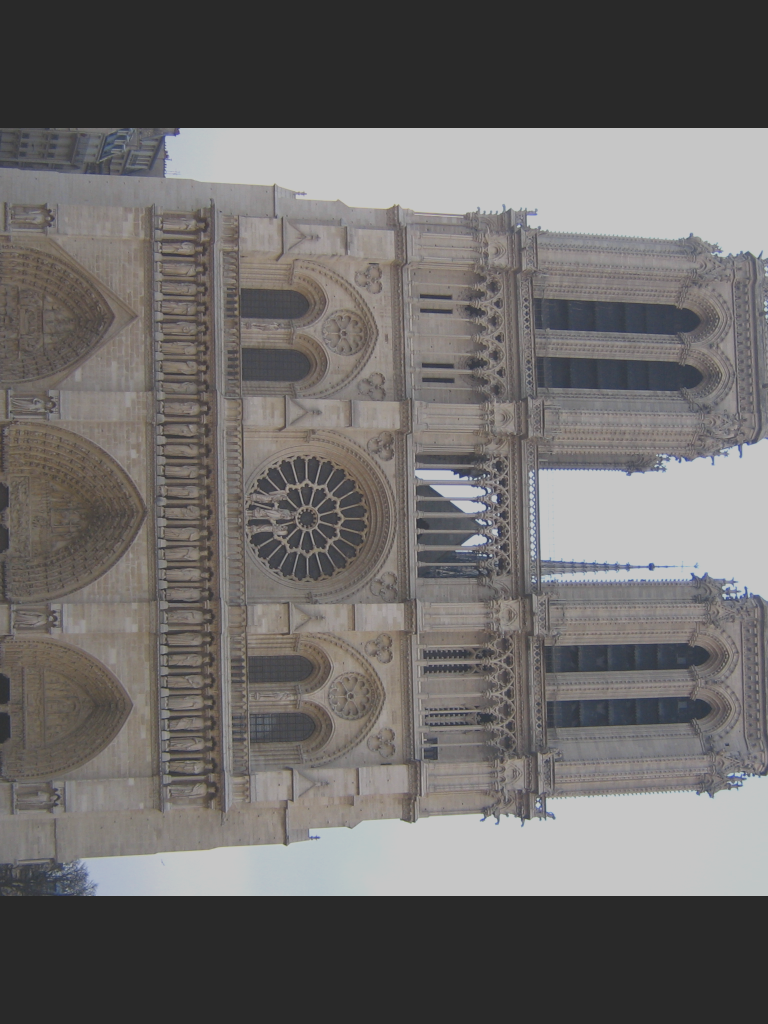

In [63]:
# convert img back to tensor
result = transforms.ToPILImage()(illumination_changed_img)
result

In [64]:
# Comparing ORB, SIFT and SOSNET implementations
img = cv2.imread('data/NotreDame1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [65]:
# sift = cv2.SIFT_create()
# keypoints = sift.detect(gray, None)

In [66]:
# plt.figure(figsize = (7,9))
# img = cv2.drawKeypoints(gray, keypoints, img)
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [67]:
# implementing ORB with opencv
# orb = cv2.ORB_create()
# keypoints = orb.detect(img, None)
# keypoints, descriptors = orb.compute(img, keypoints)

In [68]:
# plt.figure(figsize = (7,9))
# img2 = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0), flags=0)
# plt.imshow(img2)
# plt.show()

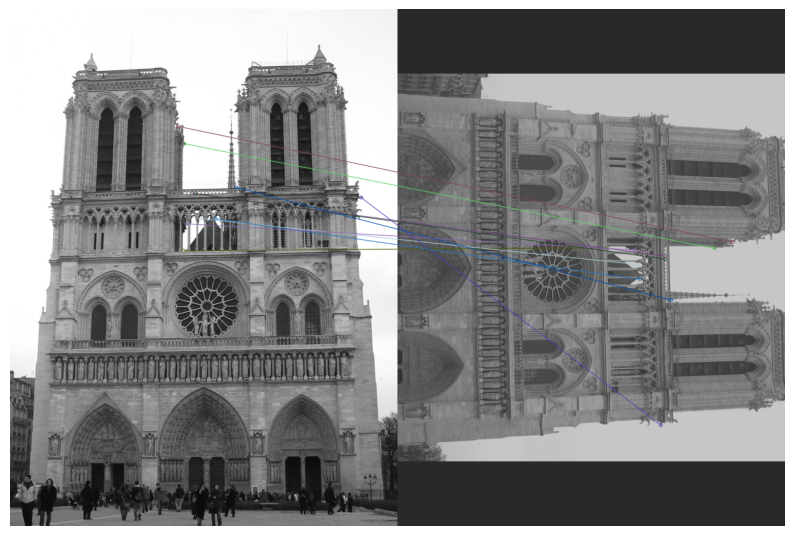

In [69]:
# Load two images
img1 = cv2.imread('data/NotreDame1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.cvtColor(np.array(result), cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors in both images
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert the BGR image to RGB (for displaying with matplotlib)
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

# Plot the matches
plt.figure(figsize=(10, 10))
plt.imshow(img_matches_rgb)
plt.axis('off')
plt.show()


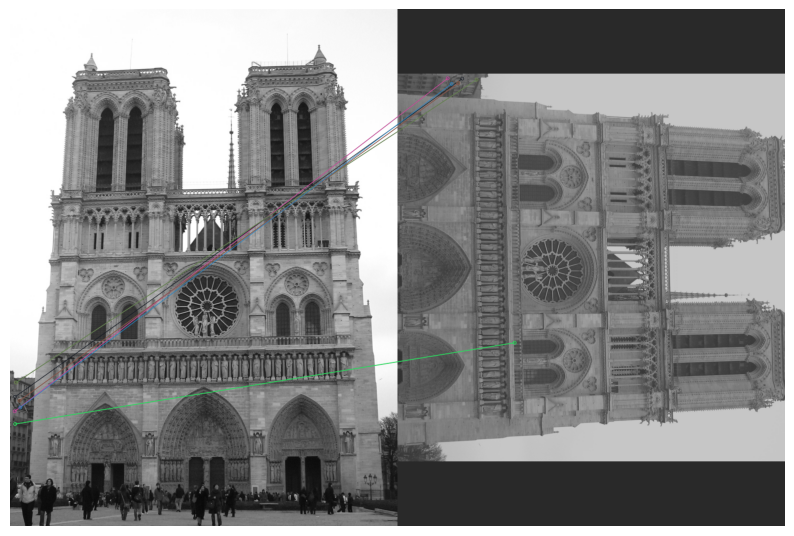

In [70]:
# Load two images
img1 = cv2.imread('data/NotreDame1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.cvtColor(np.array(result), cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in both images
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert the BGR image to RGB (for displaying with matplotlib)
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

# Plot the matches
plt.figure(figsize=(10, 10))
plt.imshow(img_matches_rgb)
plt.axis('off')
plt.show()


In [71]:
# Implementing SOSNET
# Initialise the sosnet model
sosnet32 = sosnet_model.SOSNet32x32()
net_name = 'notredame'
loaded_model_state = torch.load(os.path.join('sosnet-weights', 'sosnet-32x32-' + net_name + '.pth'), map_location=torch.device('cpu'))
sosnet32.load_state_dict(loaded_model_state)

<All keys matched successfully>

In [72]:
# load brisk keypoints 
brisk = cv2.SIFT_create()
kp1 = brisk.detect(img1, None)
kp2 = brisk.detect(img2, None)

In [73]:
print(img1.shape)

(1024, 768)


In [74]:
import math
def extract_patches(model,
                    img,
                    kpts,
                    patch_size=32,
                    mag_factor=3,
                    use_gpu=False):

    patches = []
    for kp in kpts:
        x, y = kp.pt
        s = kp.size
        a = kp.angle

        s = mag_factor * s / patch_size
        cos = math.cos(a * math.pi / 180.0)
        sin = math.sin(a * math.pi / 180.0)

        M = np.matrix(
            [[+s * cos, -s * sin, (-s * cos + s * sin) * patch_size / 2.0 + x],
             [+s * sin, +s * cos,
              (-s * sin - s * cos) * patch_size / 2.0 + y]])

        patch = cv2.warpAffine(
            img,
            M, (patch_size, patch_size),
            flags=cv2.WARP_INVERSE_MAP + cv2.INTER_CUBIC +
            cv2.WARP_FILL_OUTLIERS)

        patches.append(patch)

    patches = torch.from_numpy(np.asarray(patches)).float()
    patches = torch.unsqueeze(patches, 1)
    if use_gpu:
        patches = patches.cuda()
    descrs = model(patches)
    return descrs.detach().cpu().numpy()

In [ ]:
desc_tfeat1 = extract_patches(sosnet32, img1, kp1, patch_size=32, mag_factor=3, use_gpu=False)
desc_tfeat2 = extract_patches(sosnet32, img2, kp2, patch_size=32, mag_factor=3, use_gpu=False)

In [ ]:
# convert np to tensor
desc_tensor1 = torch.from_numpy(desc_tfeat1)
desc_tensor2 = torch.from_numpy(desc_tfeat2)

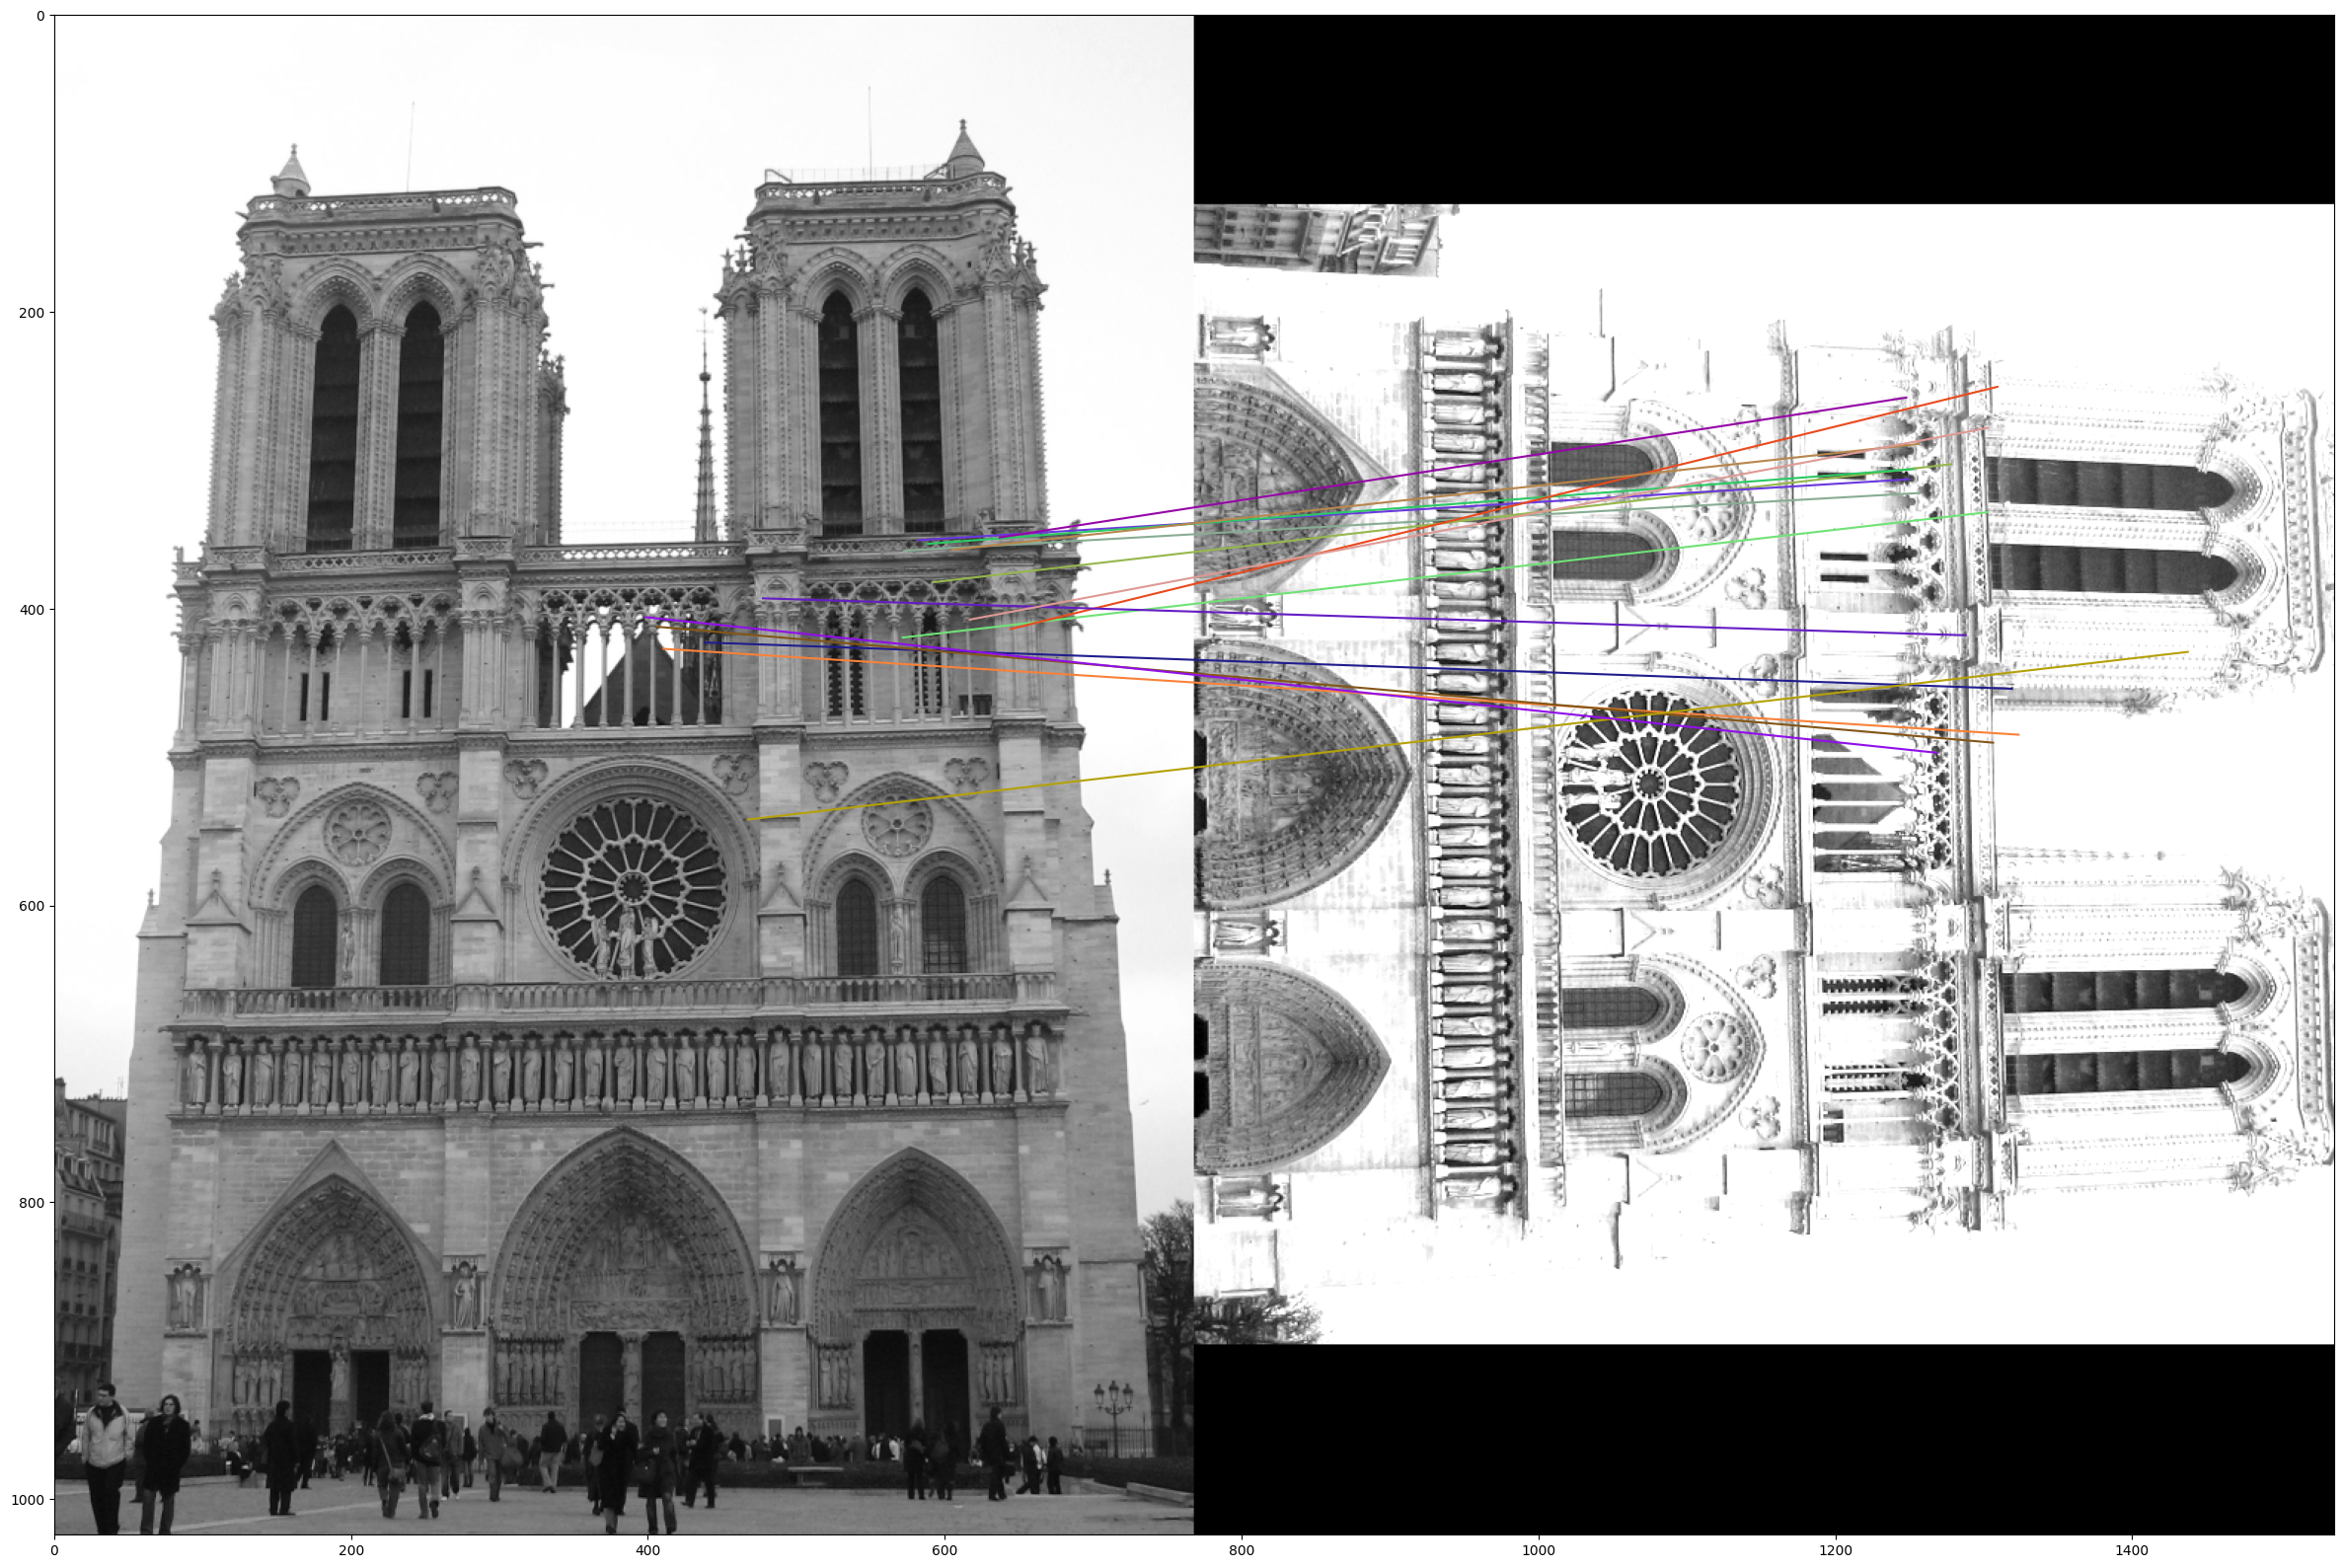

In [ ]:
from match import match
dist_test = match(desc_tensor1, desc_tensor2, device = 'cpu')
from skimage.feature import plot_matches

keypt1 = [
    [kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id] for kp in kp1
]

# Convert the list of lists into a numpy array
keypt1 = np.array(keypt1, dtype=np.float32)
keypt1 = torch.from_numpy(np.array(keypt1))

keypt2 = [
    [kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id] for kp in kp2
]

# Convert the list of lists into a numpy array
keypt2 = np.array(keypt2, dtype=np.float32)
keypt2 = torch.from_numpy(np.array(keypt2))

fig, axs = plt.subplots(figsize=(30.0, 20.0))
k = 20
plot_matches(
    axs,
    img1,
    img2,
    keypt1.cpu(),
    keypt2.cpu(),
    dist_test[:k, :],
    alignment="horizontal",
    only_matches=True,
)

plt.show()

In [ ]:
correct = 0
h, w = img1.shape

for match in matches:
    idx1, idx2 = match
    x1, y1 = keypt1[idx1].cpu().numpy()
    
    # Ground truth from the rotated image (90 degrees)
    grtr_x2, grtr_y2 = y1, w - x1
    
    # Get the matched keypoint position from the transformed image
    x2, y2 = keypt2[idx2].cpu().numpy()
    
    # Check if the match is correct
    if grtr_x2 == x2 and grtr_y2 == y2:
        correct += 1

# Calculate accuracy
accuracy = correct / matches.size(0)
print(accuracy)